# Simulate some data to test the method. branch = master

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones.dartmouth import Dartmouth_Isochrone
from isochrones import StarModel

mist = MIST_Isochrone()
dart = Dartmouth_Isochrone()

In [2]:
print(mist.bands)

['B', 'G', 'H', 'J', 'K', 'Kepler', 'V', 'W1', 'W2', 'W3', 'g', 'i', 'r', 'z']


In [3]:
plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Draw randomly from mass, age, metallicity, distance and extinction distributions.

In [4]:
N = 1000
mass, mass_err = np.random.uniform(.5, 1.2, size=N), np.ones(N)*.1
eep, eep_err = np.random.uniform(195, 480, size=N), np.ones(N)*10
age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
age_err = age*.2
feh, feh_err = np.random.uniform(-.2, .2, size=N), np.ones(N)*.01
d_kpc = np.random.uniform(.01, 1, size=N)
dkpc_err = d_kpc*.1
d_pc = d_kpc*1e3
dpc_err = d_pc*.1
av, av_err = np.random.uniform(0, 1, size=N), np.ones(N)*.01

df = pd.DataFrame(dict({"eep": eep, "eep_err": mass_err,
                        "age": age, "age_err": age_err,
                        "feh": feh, "feh_err": feh_err,
                        "d_kpc": d_kpc, "dkpc_err": dkpc_err,
                        "Av": av, "Av_err": av_err}))

Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [5]:
logg, teff, B, V, J, H, K, logL = [np.zeros(N) for i in range(8)]
for i in range(N):
    logg[i] = mist.logg(eep[i], age[i], feh[i])
    teff[i] = mist.Teff(eep[i], age[i], feh[i])
    B[i] = mist.mag["B"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    V[i] = mist.mag["V"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    J[i] = mist.mag["J"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    H[i] = mist.mag["H"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    K[i] = mist.mag["K"](eep[i], age[i], feh[i], d_pc[i], av[i])  # parsecs, not kpc!!!
    logL[i] = mist.logL(eep[i], age[i], feh[i])
    
df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"] = B - V, B, V, J, H, K
df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
df["mass"] = mist.mass(df.eep, df.age, df.feh)

Text(0,0.5,'$\\log(g)$')

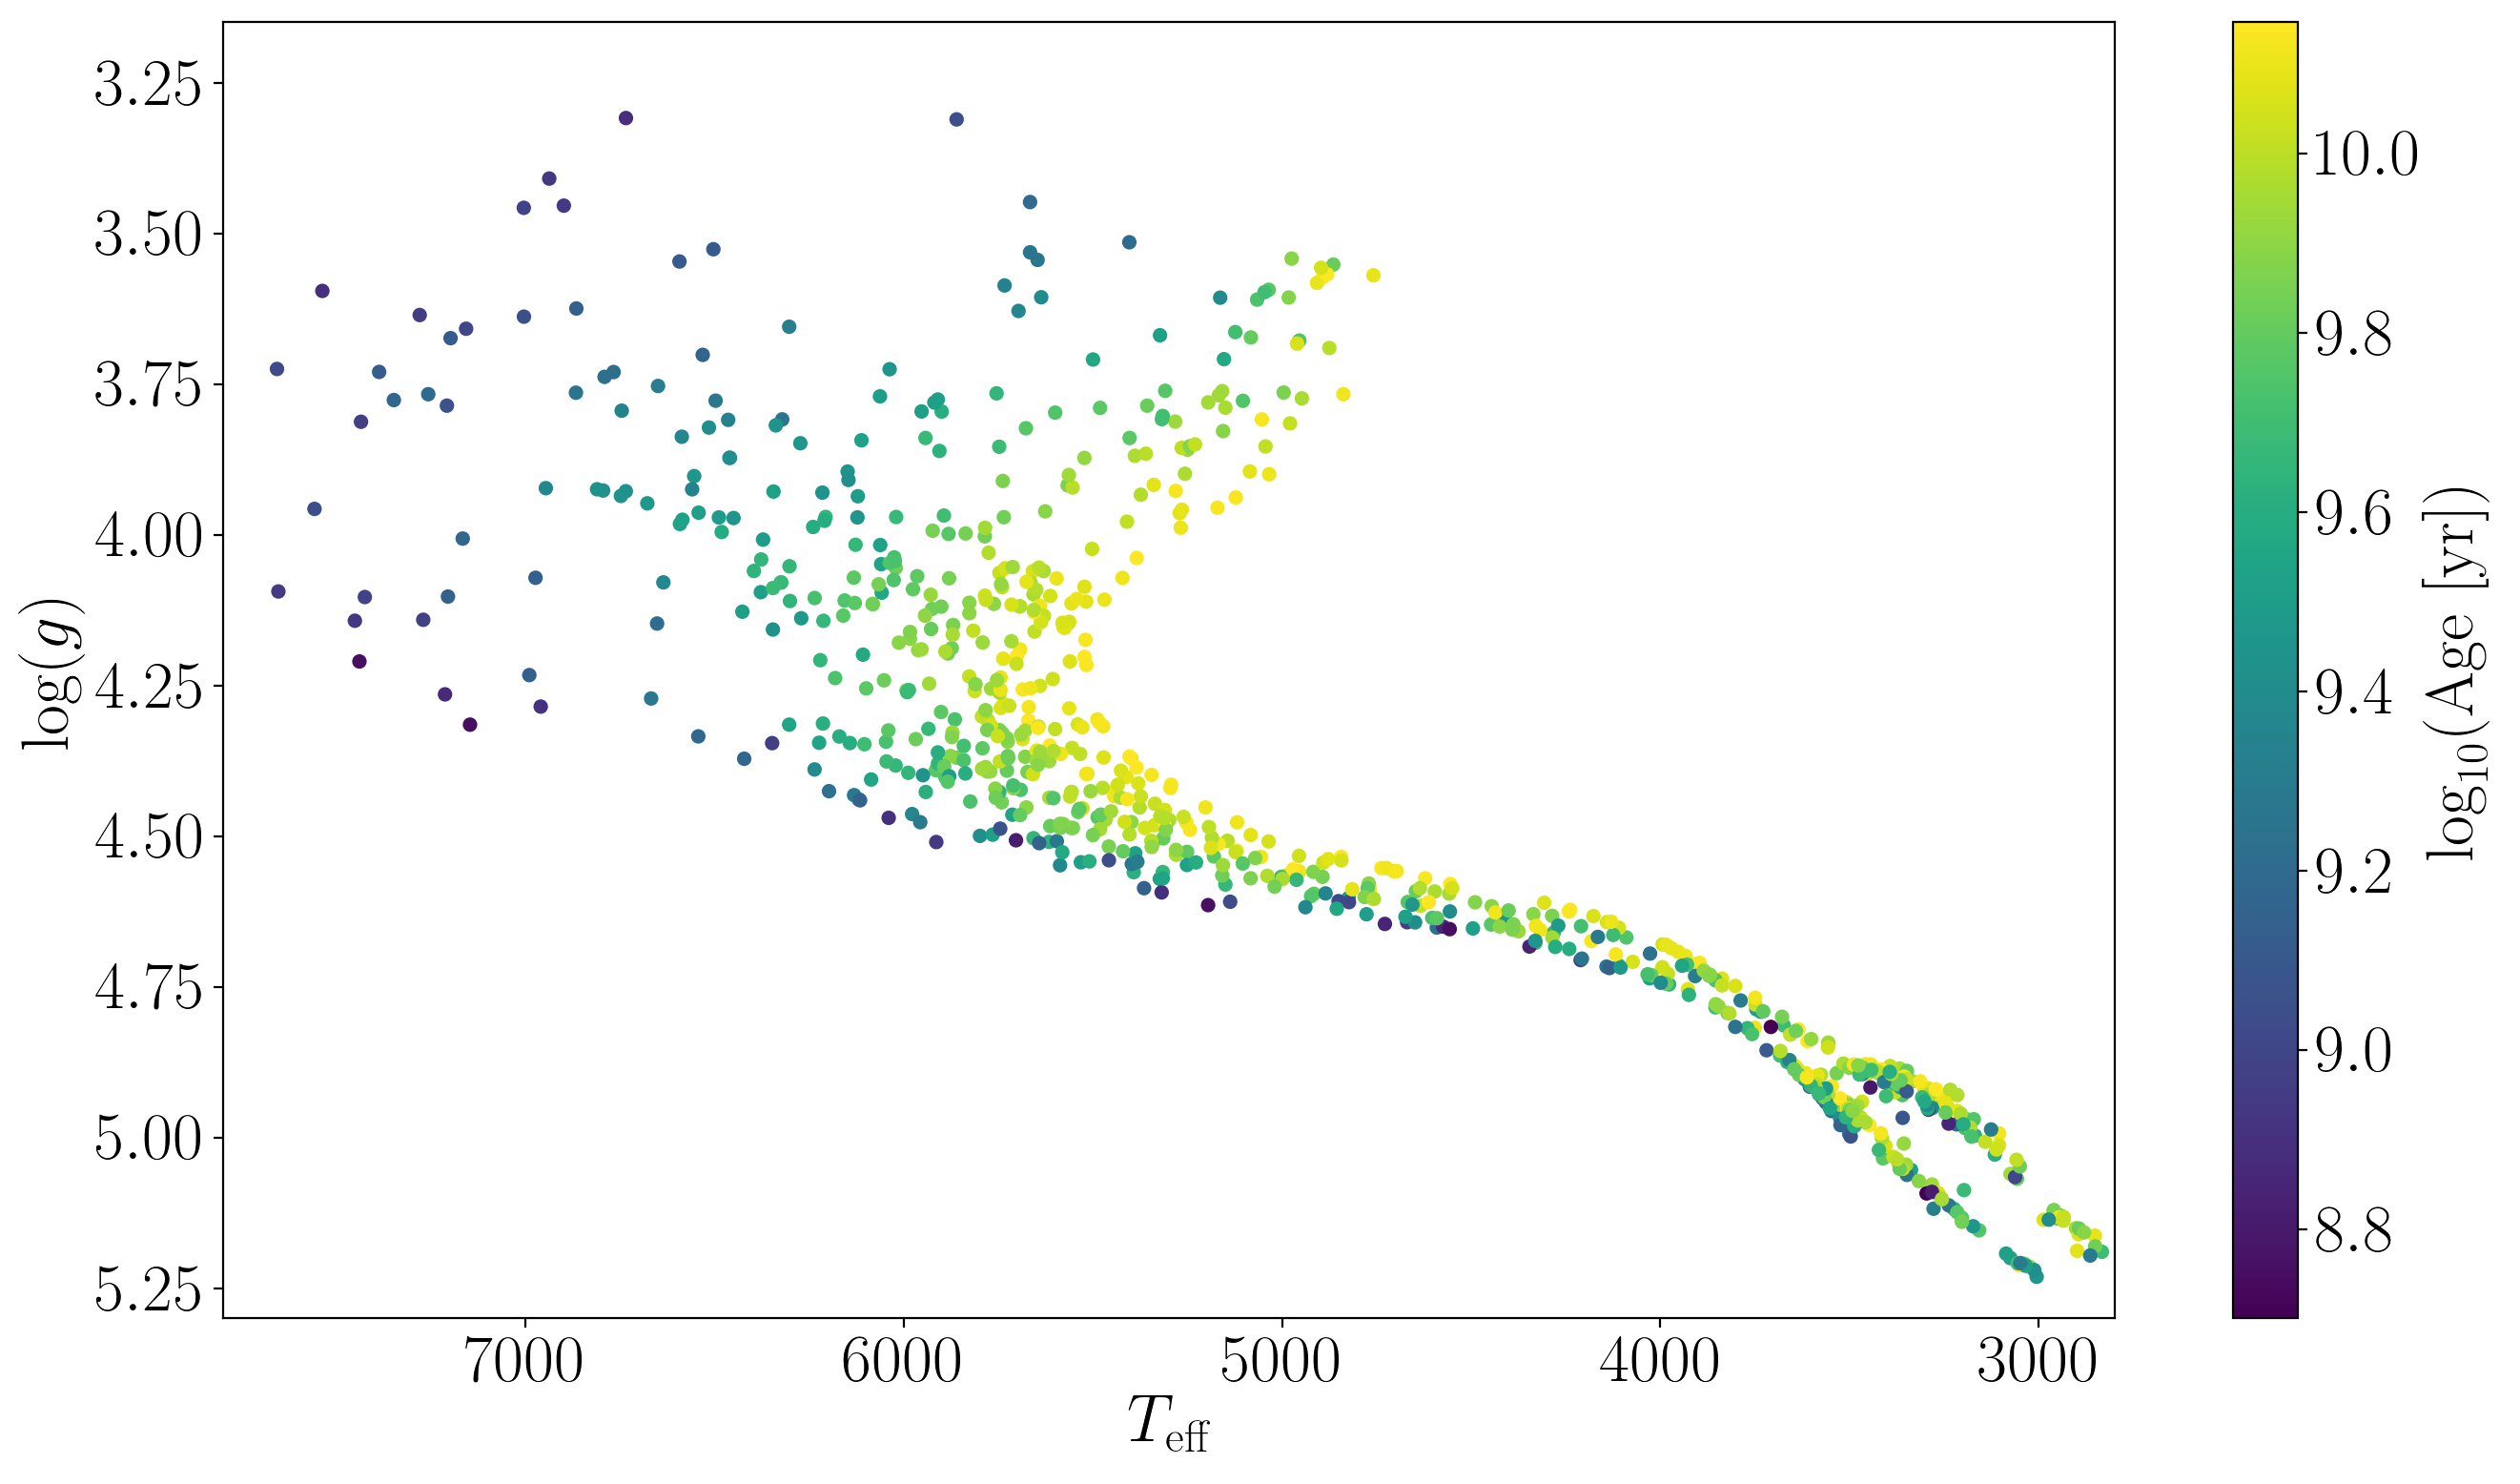

In [6]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(teff, logg, c=age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now calculate the rotation periods of these stars from their ages and B-V colours.

In [12]:
def gyro_rot(log_age_yr, bv):
    age_myr = (10**(log_age_yr))*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    return age_myr**n * a * (bv - c)**b

def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

print("Sun's rotation period = ", gyro_rot(np.log10(4.67*1e9), 0.65))

Sun's rotation period =  25.3223247576905


Cut the hot stars and the subgiants.

In [8]:
teff_lim, logg_lim = 6250, 4.4
m = teff < teff_lim
m &= logg_lim < logg

# Calculate periods. NaNs will appear for stars with B-V < 0.45, but stardate can handle this.
df["prot"] = gyro_rot(df.age, df.BV)

# Cut unphysical masses
finite_mask = np.isfinite(df.mass.values)
finite_df = df.iloc[finite_mask]
print(len(df.mass.values), len(df.mass.values[finite_mask]))

1000 897


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


In [17]:
def test_gyro_is_on(bv, eep, age, feh, prot):
    if bv > .45 and prot and np.isfinite(prot) and 0. < prot and eep < 454:
        return True, (10**gyro_age(prot, bv))*1e-9
    else:
        return False

# print(test_gyro_is_on(.65, 355, np.log10(4.56*1e9), 0., 26))
# print(test_gyro_is_on(.4, 355, np.log10(4.56*1e9), 0., 26))
# print(test_gyro_is_on(.65, 460, np.log10(4.56*1e9), 0., 26))
# print(test_gyro_is_on(.65, 355, np.log10(4.56*1e9), 0., None))

i = 1
print(df.B[i] - df.V[i], df.eep[i], (10**df.age[i])*1e-9, df.feh[i], df.prot[i])
print(test_gyro_is_on(df.B[i] - df.V[i], df.eep[i], df.age[i], df.feh[i], df.prot[i]))

0.8999462876889037 343.5997065792592 6.090979481786215 0.03801584766982341 37.68059266538993
(True, 6.090979481786215)


Text(0,0.5,'$\\mathrm{Rotation~period~[days]}$')

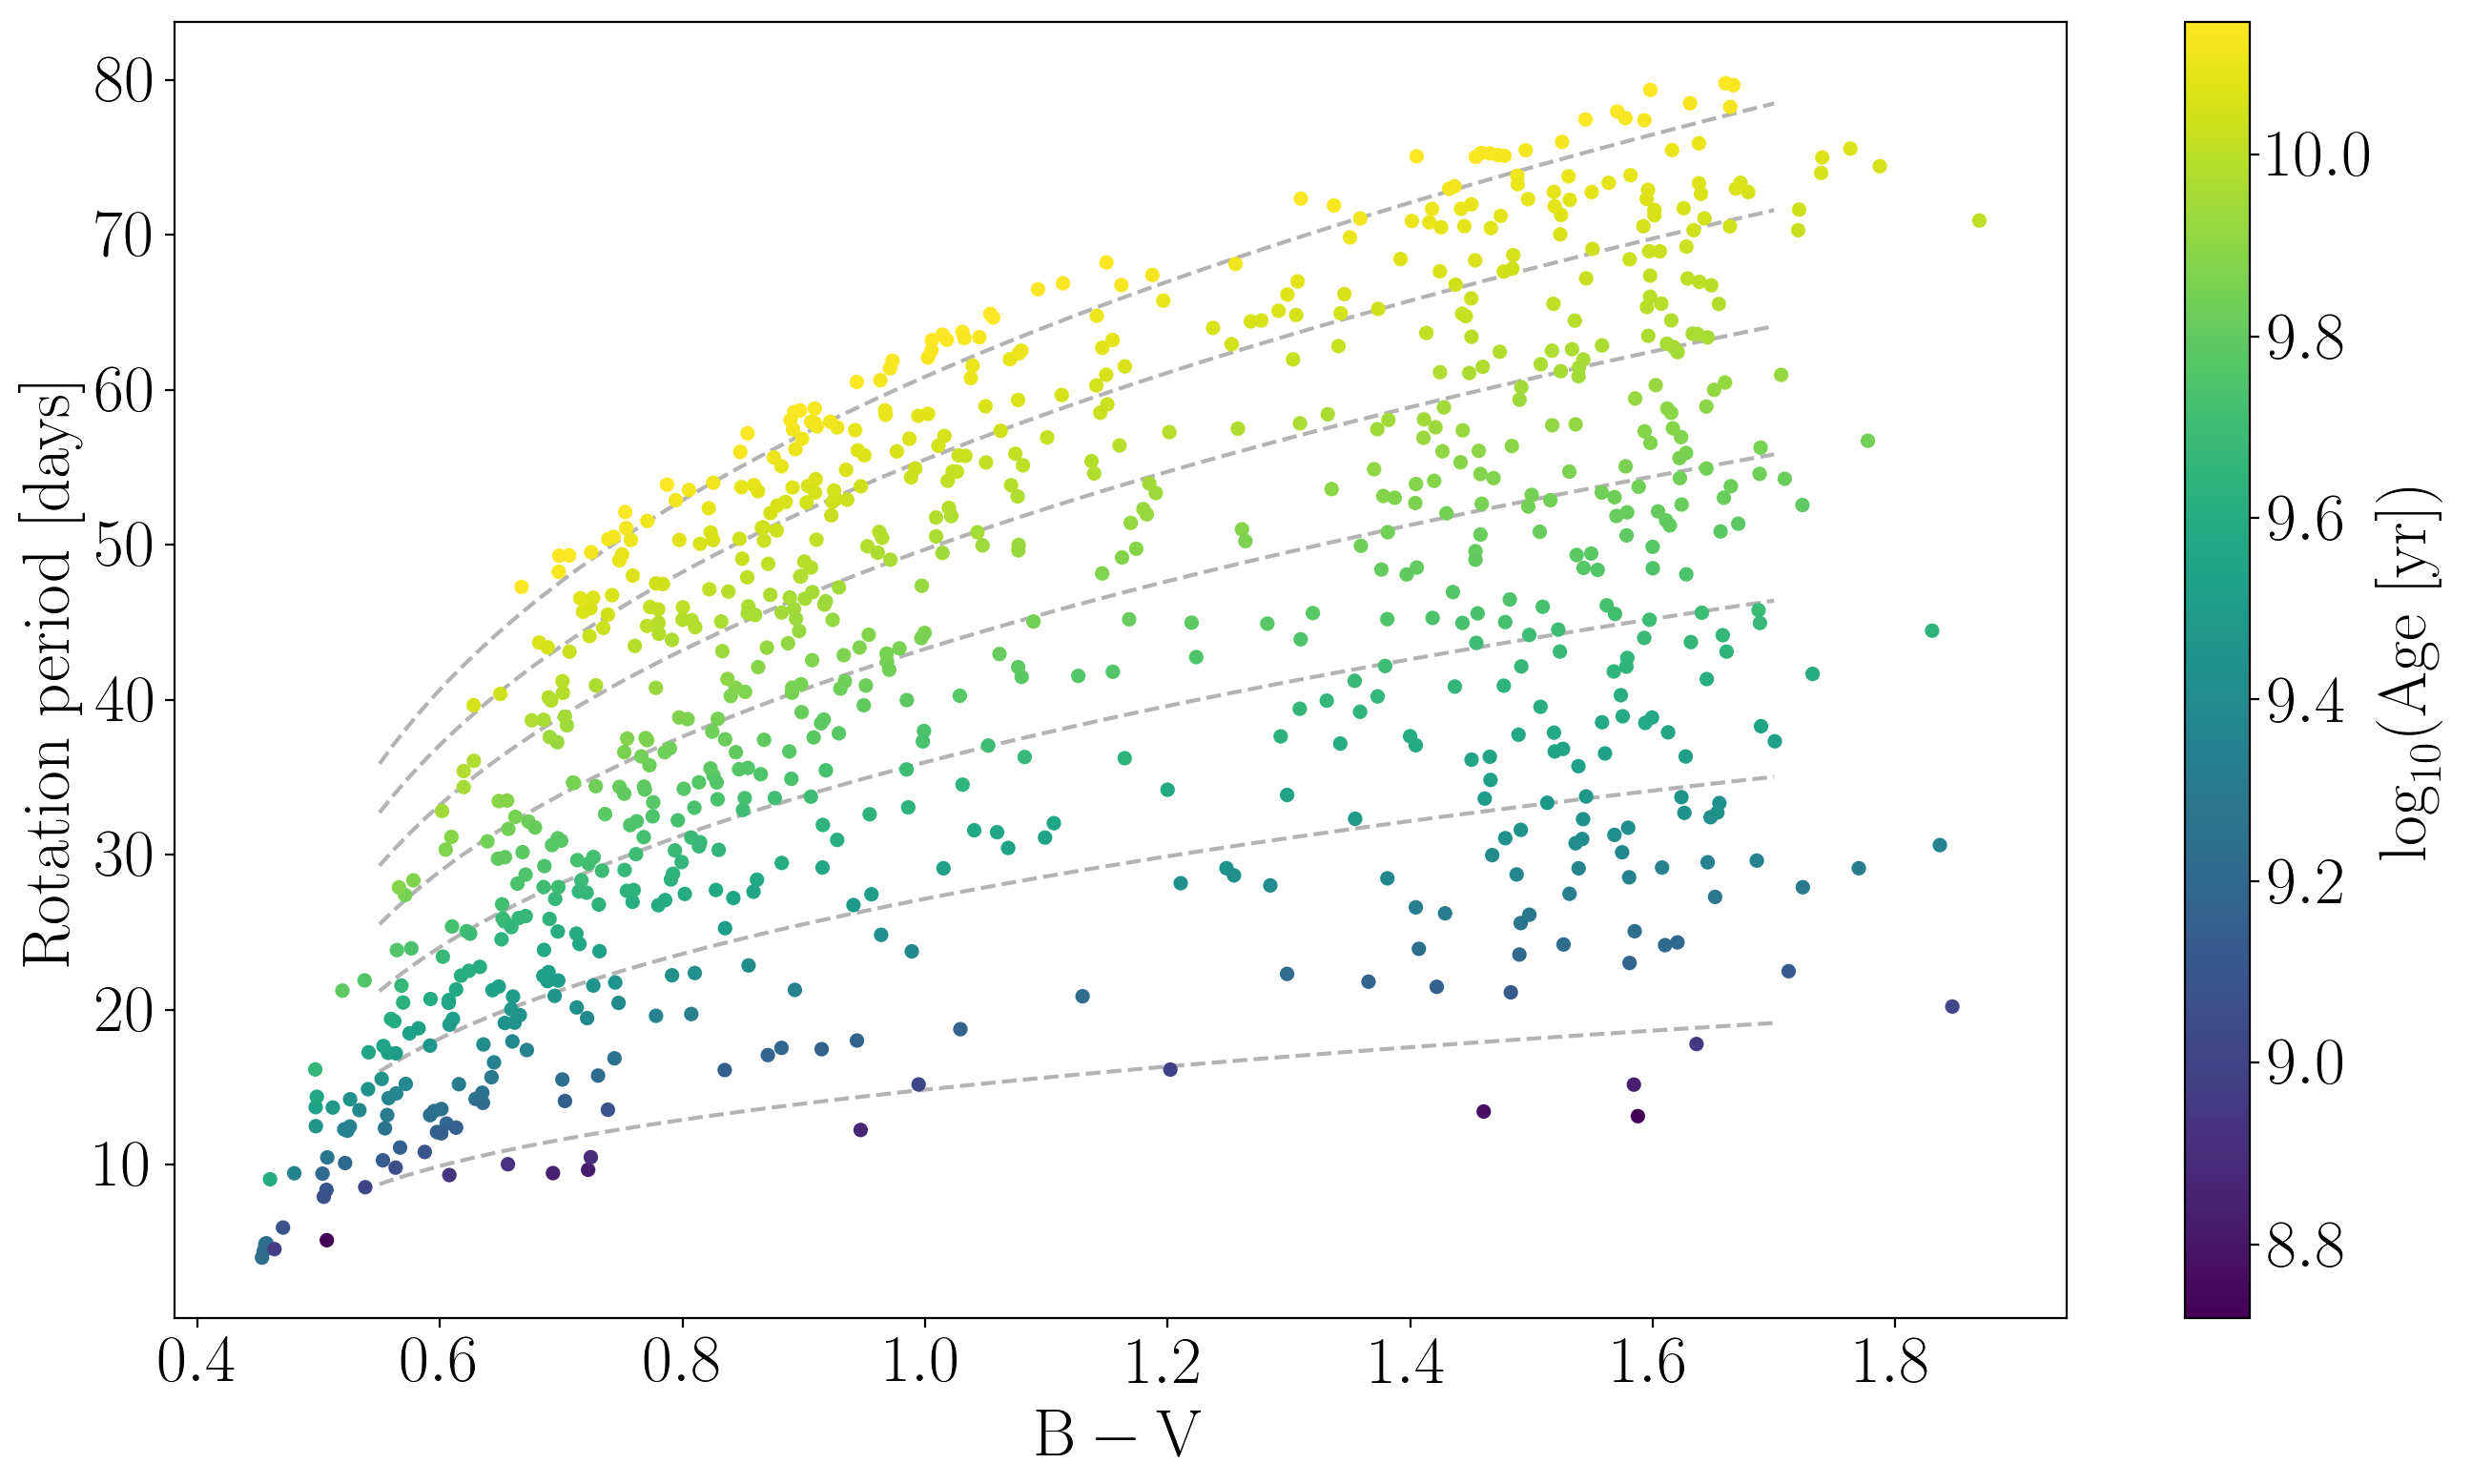

In [24]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.55, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.age, s=20, zorder=1)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

Save simulated data file.

In [25]:
finite_df.to_csv("data/simulated_data.csv")

Text(0.5,0,'$\\mathrm{Mass~}[M_\\odot]$')

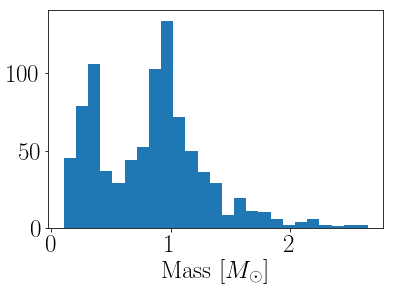

In [26]:
plt.hist(finite_df.mass, 25);
plt.xlabel("$\mathrm{Mass~}[M_\odot]$")

In [27]:
# iso = read_mist_models.ISO("data/MIST_v1.2_vvcrit0.0_UBVRIplus/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso")

# tmin, tmax = 3500, 7000
# Lmin, Lmax = -1.2, 1

# teffs, Ls, ages, eeps = [[] for i in range(4)]
# for i, a in enumerate(tqdm(np.log10(np.linspace(.1, 13.8, 100)*1e9))):

#     age_ind = iso.age_index(a) #returns the index for the desired age
#     logTeff = iso.isos[age_ind]['log_Teff']
#     logL = iso.isos[age_ind]['log_L']
#     eep = iso.isos[age_ind]['EEP']
#     age = (10**iso.isos[age_ind]["log10_isochrone_age_yr"])*1e-9
    
#     teff = 10**logTeff

#     m = (teff < tmax) * (tmin < teff)
#     m &= (logL < Lmax) * (Lmin < logL)

#     Ls.append(logL[m])
#     teffs.append(teff[m])
#     ages.append(age[m])
#     eeps.append(eep[m])
   
# teffs = np.array([i for j in teffs for i in j])
# Ls = np.array([i for j in Ls for i in j])
# ages = np.array([i for j in ages for i in j])
# eeps = np.array([i for j in eeps for i in j])